Google Drive Authentication
---

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/DrRabiee-Project/

Mounted at /gdrive
/gdrive/My Drive/DrRabiee-Project


Importing/Installing the Necessary Libraries
---

In [ ]:
!pip install lime

In [1]:
from __future__ import print_function
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import optimizers
from tensorflow import expand_dims
import numpy as np
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import seaborn as sns
import random
import bottleneck as bn
from sklearn.metrics import accuracy_score

Configuration
---

In [2]:
num_classes = 10
weight_decay = 0.0005
x_shape = [32,32,3]
batch_size = 128
maxepoches = 250
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 20

Model Architecture
---

In [3]:
model = Sequential()

model.add(Conv2D(64, (3, 3), padding='same',
                    input_shape=x_shape,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        2

Loading the Model
---

In [5]:
model.load_weights('cifar10vgg.h5')

Loading the Data
---

In [7]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

170500096/170498071 [==============================] - 1639s 10us/step


Normalizing the Data
---

In [8]:
def normalize(X_train,X_test):
    # this function normalizes inputs so that they have zero mean and unit variance
    # it is used when training a model
    # Input: training set and test set
    # Output: normalized training set and test set according to the trianing set statistics.
    mean = np.mean(X_train,axis=(0,1,2,3))
    std = np.std(X_train, axis=(0, 1, 2, 3))
    X_train = (X_train-mean)/(std+1e-7)
    X_test = (X_test-mean)/(std+1e-7)
    return X_train, X_test

In [9]:
x_train, x_test = normalize(x_train, x_test)

Performing one-hot encoding on the labels
---

In [10]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

LIME
---

In [11]:
def get_heatmap(img, model):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(img, model.predict)
    ind =  explanation.top_labels[0]
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
    return heatmap

In [12]:
# the following function gets the top n elements (in terms of magnitude) from a numpy array
def top_n_indexes(arr, n):
    idx = bn.argpartition(arr, arr.size-n, axis=None)[-n:]
    width = arr.shape[1]
    return [divmod(i, width) for i in idx]

In [13]:
# given a list of tuples (pixel indices), this function generates a list of other pixels
def get_other_pixels(idx_list):
    idx_list = set(idx_list)
    other_pixels = []
    for i in range(28):
        for j in range(28):
            if (i,j) not in idx_list:
                other_pixels.append((i,j))
    return other_pixels

In [14]:
# given an image and a heatmap showing the importance of each pixels, this function destructs the image such that only a specified percentage of
# the most important pixels remains, and the other ones get replaced by salt and pepper noise
def destruct_image(img, heatmap, percentage=0.2):
    result = img.copy()
    idx_list = top_n_indexes(heatmap, int(percentage*(28*28)))
    idx_list.sort(key = lambda tup: tup[0])
    other_pixels = get_other_pixels(idx_list)
    for idx in other_pixels:
        #random_val = random.sample([0,1], 1)[0]
        random_val = 0
        result[idx[0],idx[1],0] = random_val
        result[idx[0],idx[1],1] = random_val
        result[idx[0],idx[1],2] = random_val
    return result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


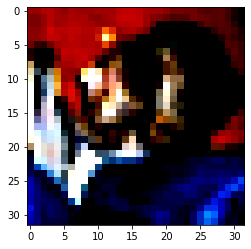

In [15]:
plt.imshow(x_test[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


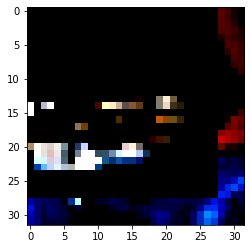

In [17]:
plt.imshow(destruct_image(x_test[0], get_heatmap(x_test[0].astype('double'), model), 0.2))

Image Desctruction: Adding Pepper Noise to the Images such that only 20 percent of the most important pixels of each one remains.
---

In [18]:
num_samples = 1000

In [19]:
new_x_test = []
for curr_img in x_test[:num_samples]:
    curr_heatmap = get_heatmap(curr_img.astype('double'), model)
    new_img = destruct_image(curr_img, curr_heatmap, 0.2)
    new_x_test.append(new_img)
new_x_test = np.array(new_x_test)

In [20]:
new_predictions = model.predict(new_x_test)

In [21]:
new_predictions = list(np.argmax(new_predictions, axis=1))
true_labels = list(np.argmax(y_test[:num_samples], axis=1))

In [22]:
accuracy_score(true_labels, new_predictions)

0.198